# Text classification with sklearn and linear models

Text classification is one of the most popular applications of NLP.
Your email checks if the message looks like spam or not (binary classification).
Your smart speaker needs to understand what action it should do when you say "what's the weather like today?".
This is a classification task over a large number of classes `get_time, get_directions, get_weather, ...` (multiclass classification).
Other popular classification tasks include news topic prediction, clickbait detection, hate speech detection, and sentiment analysis.

*Sentiment analysis* is a task where (in the simplest form) given a text you need to predict if the text is positive ("my new laptop is amazing") or negative ("the company XYZ steals our personal data"). The definitions of "positive" and "negative" generally depend on the domain of your task. For example "long-lasting smell" may carry positive sentiment in the context of perfume but might be negative in the context of a cleaning solution. Sentiment analysis systems could be used by the companies who want to understand how positive was the social media reaction to their latest announcement or in the user feedback forms to address the negative feedback quickly.

In this homework, we will be predicting the sentiment of movie reviews using IMDB dataset. First, let's use [🤗 Datasets](https://github.com/huggingface/datasets) library to download it for us.

In [6]:
!pip install datasets scikit-learn matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [7]:
import datasets
imdb = datasets.load_dataset("imdb")

🤗 Datasets is a popular [library](https://huggingface.co/docs/datasets) and a [repository](https://huggingface.co/datasets) of datasets.
It can be used to download pre-existing datasets, pre-process them, and could be applied to your own datasets too.
In this homework we will mostly just use it to download the dataset and look at some of its statistics, but in the future, you will learn more about it.

Let's look at the dataset we have just downloaded.

In [8]:
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

We see that `imdb` has type `DatasetDict` and it consists of three parts (commonly called "splits"): `train`, `test`, and `unsupervised`. All of these have the type `Dataset`. The subset `train` has 25000 examples and we will use it to train our model, `test` also contains 25000 examples (which is an uncommonly large size of test size, usually test is significantly smaller than train). Both of these splits have fields `text` and `label` containing the movie review text and a label if the review is positive or not.

`unsupervised` set does not have labels (all of them are -1 irregardless of their sentiment). More advanced ML methods can utilize this to improve model accuracy, but we will not use it in this homework.

# Coding Task 1
Let's look at a couple of examples from the train split. You can index the `Dataset` object just like usual python arrays providing the index in square brackets, for example  `train_set[0]` with return you the first element of the dataset. Try looking at the first and the last elements.

In [9]:
train_set = imdb["train"]

In [ ]:
# Get the first element of the train_set
# YOUR CODE HERE
import datasets
imdb = datasets.load_dataset("imdb")
train_set = imdb["train"]
firstElement = train_set[0]
print(firstElement)


{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [13]:
# Get the last element of the train_set
# YOUR CODE HERE
# Run these to check if runs as intended i.e. the formatting is correct
import datasets
imdb = datasets.load_dataset("imdb")
train_set = imdb["train"]
lastElement = train_set[-1]
print(lastElement ) 


{'text': 'The story centers around Barry McKenzie who must go to England if he wishes to claim his inheritance. Being about the grossest Aussie shearer ever to set foot outside this great Nation of ours there is something of a culture clash and much fun and games ensue. The songs of Barry McKenzie(Barry Crocker) are highlights.', 'label': 1}


## Dataset statistics

A good first thing to do when you see a new dataset is to look at its statistics. For example at the distributions of classes, and lengths of the texts.

We can use python [list comprehension](https://www.w3schools.com/python/python_lists_comprehension.asp) and function `sum` to quickly get the answer to our first question.

In [15]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


N positive:  12500
N negative:  12500


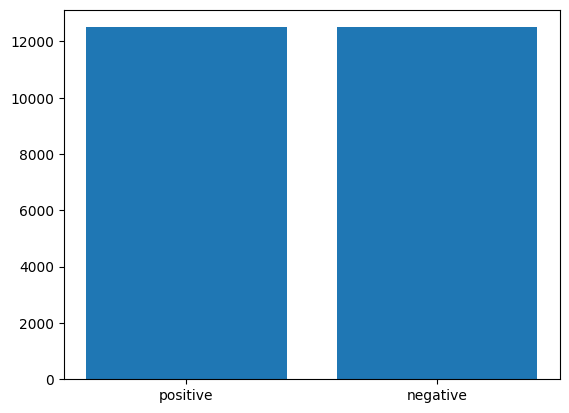

In [16]:
n_positive_examples = sum(label == 1 for label in train_set["label"])
n_negative_examples = sum(label == 0 for label in train_set["label"])

plt.bar(x=["positive", "negative"], height=[n_positive_examples, n_negative_examples])
print("N positive: ", n_positive_examples)
print("N negative: ", n_negative_examples)

Looks like the training set is perfectly balanced. What about the test set?

# Coding Task 2

Compute the number of positive and negative labels in the test set. Print the numbers and make a matplotlib barplot in the same way we did above.

N positive:  12500
N negative:  12500


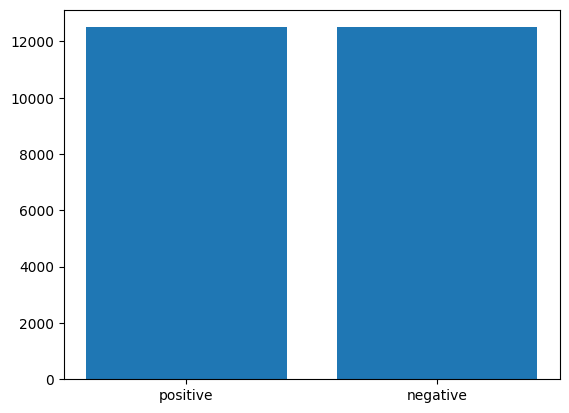

In [ ]:
# YOUR CODE HERE

import matplotlib.pyplot as plt
import datasets
imdb = datasets.load_dataset("imdb")
test_set = imdb["test"]

n_positive_examples = sum(label == 1 for label in test_set["label"])
n_negative_examples = sum(label == 0 for label in test_set["label"])

plt.bar(x=["positive", "negative"], height=[n_positive_examples, n_negative_examples])
print("N positive: ", n_positive_examples)
print("N negative: ", n_negative_examples)

Now let's plot the distributions of the number of words in the dataset. For now, we will define "word" as a contiguous sequence of characters that does have a space symbol.

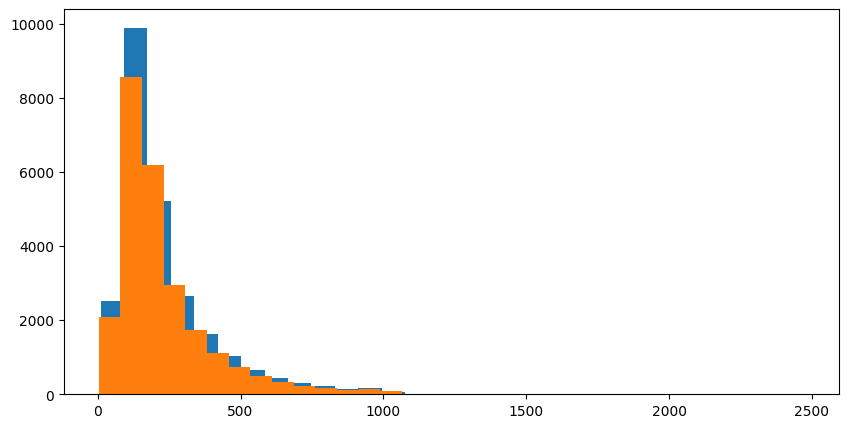

In [20]:
n_words_train = [len(text.split(" ")) for text in train_set["text"]]
n_words_test = [len(text.split(" ")) for text in test_set["text"]]

plt.figure(figsize=(10, 5))
plt.hist(n_words_train, bins=30, label="train")
plt.hist(n_words_test, bins=30, label="test");

Some of these texts are quite long. Fortunately, this is not a problem for the methods we are going to use today.

## What metric to use

Now that we understand the label distribution in our dataset, we can consider appropriate evaluation metrics. Since we have a balanced binary classification task, accuracy is a reasonable choice.

### Inline Questions

**Q1:** What is the accuracy of the worst possible predictor on a balanced test set (binary classification)?

**A:** 0% - The worst possible predictor would predict the wrong class for every example, resulting in 0% accuracy.

**Q2:** Imagine you have a predictor *A* that has 0% accuracy on your balanced binary classification task and another predictor *B* that has 50% accuracy on the same test set. Which model is actually worse? Can you improve any of these predictors with some simple post-processing of the results (the binary prediction)?

**A:** Predictor A (0% accuracy) is actually better than predictor B (50% accuracy). This is because predictor A is perfectly wrong - it's predicting the opposite of the true labels. We can improve predictor A by simply inverting all its predictions, which would give us 100% accuracy. Predictor B with 50% accuracy is just random guessing and cannot be improved through simple post-processing.

**Q3:** Should the accuracy 99% be considered "good" for any binary classification dataset?

**A:** It depends on the dataset and task. For a balanced dataset, 99% accuracy is generally very good. However, for an imbalanced dataset (like one with 99.9% of one class), 99% accuracy could be achieved by simply predicting the majority class and would not indicate good performance. The context and difficulty of the task also matter - some tasks may be inherently easier or harder than others.

**Q4:** Imagine that you have a binary classification dataset that has 99.9% of one class and 0.1% of the other. What is the best possible accuracy for a predictor that completely ignores the text?

**A:** 99.9% - A predictor that always predicts the majority class would achieve 99.9% accuracy by simply predicting the majority class for every example.

**Q5:** Is it a good idea to use accuracy as the main metric in the example above? Are there any other metrics that would work better in this situation?

**A:** No, accuracy is not a good metric for this imbalanced dataset. Better metrics would include:
- Precision and Recall: These metrics focus on the performance of the minority class
- F1-score: Combines precision and recall into a single metric
- ROC-AUC: Measures the model's ability to distinguish between classes
- Precision-Recall AUC: Particularly useful for imbalanced datasets
These metrics would better reflect the model's actual performance on the minority class, which is often the class of interest in imbalanced scenarios.

## Text vectorization

In the class, we have talked about possibly the simplest way to represent text to a computer: bag-of-words (BoW) approach. BoW assumes that the order of the words in the text does not matter. Sounds ridiculous? We will see it in action soon. Now, let's look into how it works.

Scikit-learn (`sklearn`) is a popular framework for *Classical ML* and it includes many machine learning models including nearest-neighbors, trees, SVMs, and linear models.
Also, it includes different pre-processing techniques. We will explore text vectorizers, namely `CountVectorizer` and `TfidfVectorizer`.

Both of these vectorizers describe every text with a fixed-sized vector, where every vector position has a word associated with it.
The difference between them is what numbers we set to these vector positions.

`CountVectorizer` is the more simple one, because for it the number is just how many times the word appears in the text. For example, if your text is "can a canner can a can", it could be described with a vector [3, 2, 1] where 3 is the count of the word "can", 2 -- "a", and 1 -- "canner". In order for the vectors to be meaningful, the vectorizer needs to have a defined vocabulary of words it accounts for and the defined order of the words in the vocabulary so that the index 0 would always correspond to a word "can" in any text.

Let's create a `CountVectorizer` object.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
count_vectorizer

CountVectorizer()

It is not very useful right now. If you will try to use it to vectorize text (`.tranform` method),
it will return you `NotFittedError: Vocabulary not fitted or provided`, because we have not defined the vocabulary for it.

In [22]:
# you can uncomment this like and check that it fails if count_vectorizer is not fitted
count_vectorizer.transform(["text"])

NotFittedError: Vocabulary not fitted or provided

We can provide this vocabulary directly, but a more convenient way to work with sklearn vectorizers is to make them infer the vocabulary on a set of texts using `.fit` method.

In [23]:
toy_texts = ["this is a small text", "this is another small text"]

count_vectorizer = count_vectorizer.fit(toy_texts)
count_vectorizer.vocabulary_

{'this': 4, 'is': 1, 'small': 2, 'text': 3, 'another': 0}

Now, we can vectorize a text like this



In [24]:
count_vectorizer.transform(["text"]).todense()

matrix([[0, 0, 0, 1, 0]])

In [25]:
count_vectorizer.transform(["text text"]).todense()

matrix([[0, 0, 0, 2, 0]])

As you can see, the text "text" has 0s everywhere, except position 3, which corresponds to the number of times the word "text" appears (see the vocabulary one cell above).

**Note:** `.todense` here transforms a sparse matrix that `.transform` returns into a dense matrix, you can learn more about [sparce maticies](https://en.wikipedia.org/wiki/Sparse_matrix), but it is not necessary for the purpose of this class.

# Coding Task 3

What if we vectorize text that has words outside vocabulary (out-of-vocabulary, OOV)? What if it only consists of them? Try vectorizing such texts

In [ ]:
# vectorizing a text with a OOV word
# YOUR CODE HERE
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
count_vectorizer

In [ ]:
# vectorizing a text that only has OOV words
# YOUR CODE HERE
count_vectorizer.transform(["unknown word"]).todense()


Now, let's try `TfidfVectorizer`. It has pretty much the same interface as `CountVectorizer`. We will see that if we fit it on the same examples, we have the same vocabulary, and the vector for the text "text" is the same, but the vectors for the text "another text" will be different for `TfidfVectorizer` and `CountVectorizer`.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer = tfidf_vectorizer.fit(toy_texts)
tfidf_vectorizer.vocabulary_

In [ ]:
tfidf_vectorizer.transform(["text"]).todense()

In [ ]:
print("Count Vector:", count_vectorizer.transform(["another text"]).todense())
print("Count Vector:", tfidf_vectorizer.transform(["another text"]).todense())

This happens for two reasons:

**First,** TfIDF is computed as two terms: term frequency (TF) or how many times we see the word in this text and inverse document frequency (IDF) or how many documents have this word in them.

TF of a word is exactly what `CountVectorizer` do, just how many times we see a word in this particular text.

IDF of a word is the number of documents in the training corpus that have this word (by training corpus we mean the texts we used to fit this vectorizer). More specifically, 1 divided by this number, hence, inverse.

TF-IDF vectors usually work better than just Count Vectors in practice.


**Second,** sklearn just uses normalization for the term frequency in `TfidfVectorizer` by default (i.e., it divides the vector by the number of words in the text), but doesn't do this for `CountVectorizer` for some reason. This normalization helps machine learning models to train more easily.


There are multiple ways of combining these two values, the simplest being just multiplying them.

`tfidf = TF * IDF`

where

`TF = word_count_in_text / total_words_in_text`

`IDF = (document_count_with_this_word / total_documents) ** -1`

> Sklearn uses a slightly different formula to better account for OOV and make the vectors less probable to cause computational errors idf(t) = log [ (1 + n) / (1 + df(t)) ] + 1. You can look it up in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer).

## Training a model

Now let's fit a vectorizer on our training set of IMDB and train our first text classifier.

In [ ]:
vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(train_set["text"])
len(vectorizer.vocabulary_)

In [ ]:
vectorized_texts = vectorizer.transform(train_set["text"])
vectorized_texts.shape

This matrix has the shape `[num_examples, vector_size]`.
We can see that the size of the text vector now is very big,
because large collection of texts contains a lot of different words,
meaning large vocabulary, meaning large vector size.

Fortunately, this is not a problem for logistic regression, which is incredibly fast to train. (Ignore the warning, it means that LogisticRegression is not fully converged, but it is fine).

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model = model.fit(vectorized_texts, train_set["label"])

Now we have a model that can do sentiment analysis for us! This is how you can use it

In [ ]:
def predict_sentiment(text, model, vectorizer):
    text_vector = vectorizer.transform([text])
    prediction = model.predict(text_vector)[0]
    if prediction == 1:
        return "Positive"
    return "Negavie"

In [ ]:
predict_sentiment("this is an amazing movie!", model, vectorizer)

# Coding task 4

Play with the model you have just trained and try to find examples where it

1. **correctly** predicts **positive** sentiment
1. **correctly** predicts **negative** sentiment
1. **incorrectly** predicts **positive** sentiment
1. **incorrectly** predicts **negative** sentiment

In [ ]:
# YOUR CODE HERE 
# Correctly predicts positive sentiment
print("Correctly predicts positive sentiment:")
print(predict_sentiment("I absolutely loved this movie! The acting was brilliant and the plot was engaging.", model, vectorizer))

# Correctly predicts negative sentiment
print("\nCorrectly predicts negative sentiment:")
print(predict_sentiment("This movie was terrible. The acting was awful and the plot made no sense.", model, vectorizer))

# Incorrectly predicts positive sentiment
print("\nIncorrectly predicts positive sentiment:")
print(predict_sentiment("The movie was not good at all, I hated every minute of it.", model, vectorizer))

# Incorrectly predicts negative sentiment
print("\nIncorrectly predicts negative sentiment:")
print(predict_sentiment("The movie was okay, nothing special but not bad either.", model, vectorizer))

Inline question

**Q6-9:** Model behavior explanation:

1. Correct positive: Strong positive words ("loved", "brilliant", "engaging") indicate positive sentiment


2. Correct negative: Clear negative words ("terrible", "awful", "no sense") indicate negative sentiment

3. Incorrect positive: Model focuses on "good" without considering negation "not"

 4. Incorrect negative: Model misses neutral/positive context of "okay" and "not bad"

## Evaluating the model

We can see that model works. Kind of. How well exactly does it work? Let's compute accuracy on the test set.

In [ ]:
from sklearn.metrics import accuracy_score

vectorized_texts_test = vectorizer.transform(test_set["text"])
test_set_predictions = model.predict(vectorized_texts_test)

print("Test accuracy is ", accuracy_score(y_true=test_set["label"], y_pred=test_set_predictions))

Not too bad! 86% accuracy (on a balanced test set) using a really simple text representations that do not even account for the word order.

Inline question:

Q10: Can we use a different vectorizer here?
For example, can we fit a new CountVectorizer on the test set
and use it instead of vectorizer we fitted on the train set?

A: No, we cannot use a different vectorizer fitted on the test set. This would be incorrect because:

1. It violates the principle of using the test set only for evaluation, not for training
2. The vocabulary learned from the test set would be different from what the model was trained on
3. This would lead to a mismatch between the feature space used during training and testing
4. It could artificially inflate performance metrics since the test set vocabulary would be optimized for those specific examples

We must use the same vectorizer that was fitted on the training data to transform the test data, ensuring consistent feature representation across both sets.

# Coding task 5
### Optimizing pre-processing and hyperparameters

Your next task is to improve the model and achieve more than 90% test accuracy. To simplify the experimentation, we provide you with a shorter code that builds a vectorizer, model, and evaluates everything in just a couple of lines of code.

To improve the results you can play with different vectorizers, with different vectorizer parameters, and model regularization. We recommend comparing `CountVectorizer` with `TfidfVectorizer`, learning about ngrams, and controlling for the maximum number of features. For the model, we recommend tuning the regularization parameter. You can check all of these parameters out in the sklearn documentation.

1. [CountVectorizer documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
1. [TfidfVectorizer documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
1. [LogisticRegression documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

> reading the documentation is an essential skill and it's better to start learning it as soon as possible


Feel free to use other models from sklearn too (this is not necessary to achieve 90% accuracy).

**NOTE:** It is ok to be stuck on this task for a bit, but if you can't seem to achieve more than 90% accuracy, feel free to contact our TA.

In [ ]:
# YOUR CODE HERE (you can base it on the code provided)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = vectorizer.fit_transform(train_set["text"])
y = train_set["label"]

In [ ]:
# YOUR CODE HERE

model = LogisticRegression()
model.fit(X, y)

X_test = vectorizer.transform(test_set["text"])
y_test = test_set["label"]
model.score(X_test, y_test)  # computes accuracy

# Submitting your solution

1. Restart the jupyter kernel and run the whole notebook (there's a single button to do this on the top panel). Make sure that the notebook executes completely without any issues. If you have bugs in the submitted notebook, this will affect your grade for this homework.

2. Make sure you have answered all of the written questions (Q1-Q10) and have solved all of the coding tasks (5 in total).

3. Submit your notebook (executed top-to-bottom as in step 1) to blackboard.